1. Difficulty evaluation using trajectory rewards

Visualization of the state

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


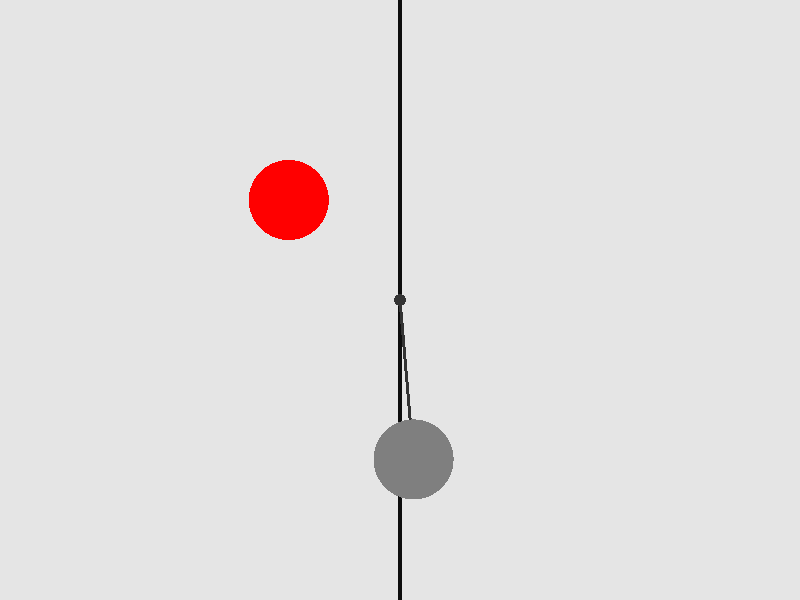

In [11]:
%load_ext autoreload
%autoreload 2

from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau, CyclicLR, StepLR

from copy import copy

import matplotlib
import torch
from IPython.core.display import clear_output
from torch.nn import LeakyReLU, functional as F

from framework import TrajectoryRewardsEvaluator, QEvaluator, DQNAgent, SeededGenerator
from pendulum import PendulumEnvironment, PendulumRenderer, PendulumState
from pendulum.heuristic import *
from shared_parameters import *
from utils import mean, running_average, MLP, sample_from
from utils import save, load, set_matplotlib_colors

set_matplotlib_colors(matplotlib, text_color="black", label_color="black", other_color="black")
import matplotlib.pyplot as plt

torch.set_printoptions(sci_mode=False)

env = PendulumEnvironment(*pendulum_env_args, time_scale=5, step_reward=1.0, action_reward=-0.1, death_reward=-100.0)
renderer = PendulumRenderer(bob_radius, connector_length, enemy_radius, enemy_y)

renderer.render(env.get_starting_state(), to_image=True)


### Note for all difficulty estimators

Currently, we have a small embedding space (just one dimension),
thus it's possible to pre-evaluate it directly, and then use the
cached difficulty evaluations.

Within the bigger space it's not possible, and we will have to
come up with some clever way of caching, where we don't store the
evaluation for every point space, but neither perform an evaluation
each time for each point.

### Direct difficulty estimation

In [2]:
oracle = HeuristicPendulumEvaluator(connector_length, max_angle, enemy_radius, bob_radius)
state = env.get_starting_state()
difficulty = oracle(state.enemy_x)

print(state.to_string())
print(f"difficulty: {difficulty.item():.3f}")

PendulumState(
  angle: 0.56,
  angular_speed: 0.05,
  vertical_position: 0.00,
  enemies: 0.29
)
difficulty: 0.360


### Difficulty estimation using trajectory rewards

In [3]:
skills = [1.0, 0.5, 0.0]
weights = [0.5, 0.25, 0.25]
agents = [HeuristicPendulumActor(enemy_radius, bob_radius, connector_length, enemy_y, skill=skill) for skill in skills]
oracle = TrajectoryRewardsEvaluator(env, agents, weights, num_evaluations=10, max_trajectory_length=20)

states = torch.vstack([env.get_starting_state() for _ in range(10)])
print(oracle.evaluate(states.enemy_x))
print(oracle.evaluate_states(states))

tensor([[0.9462],
        [0.6668],
        [0.8669],
        [0.8541],
        [0.7835],
        [0.8350],
        [0.6793],
        [0.8097],
        [0.7635],
        [0.1003]])
tensor([[0.1974],
        [0.8468],
        [0.3411],
        [0.9459],
        [0.8300],
        [0.4090],
        [0.7457],
        [0.2457],
        [0.9165],
        [0.8533]])


### Difficulty estimation using Q-values

1. Train agents, save at time steps
2. Use them in QEvaluator

In [68]:
agent = DQNAgent(PendulumState.get_size(1), action_size=2, hidden=[8, 8], activation=LeakyReLU())
total_rewards = []
agents = []

Run next cell to train the agent until you're satisfied. Run the cell above it to save the agent

loss: 100.19352722167969. Mean total reward: -12.159292929292928


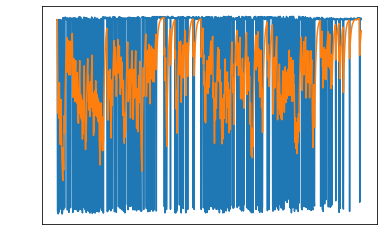

In [169]:
# Train the agent for N iterations
agent.eval = False
loss = agent.train(env, epochs=100, max_trajectory_length=20)
agent.eval = True

for _ in range(10):
    state = env.get_starting_state()
    total_reward = 0.0

    for _ in range(20):
        action = agent.get_action(state)
        state, reward, done = env.transition(state, action)
        total_reward += reward
        if done:
            break

    total_rewards.append(total_reward)
    if len(total_rewards) > 1000:
        total_rewards.pop(0)

clear_output(wait=True)
print(f"loss: {loss}. Mean total reward: {mean(total_rewards)}")
plt.plot(total_rewards)
plt.plot(running_average(total_rewards))
plt.show()

In [170]:
# Use this to append an agent
original = agent
agents.append(copy(agent))
print(f"Total of: {len(agents)} agents")
save(agents, "./saved_data/saved_agents.pt")

for agent in agents:
    print(list(agent.nn.parameters())[0].data)

agent = original

Total of: 3 agents
tensor([[ 0.4019,  1.1136,  0.7463,  0.8107],
        [-0.8324,  0.7543,  1.3992,  0.5988],
        [-0.8337, -1.5419, -1.2075,  1.8122],
        [-0.6334,  1.2466,  0.3922,  0.5572],
        [-0.9401,  0.3301,  0.4408, -0.2868],
        [ 1.7932,  2.1702,  0.8041, -0.3117],
        [ 0.0614,  1.0410,  1.3135, -0.1084],
        [ 0.4259,  4.3069,  0.4547,  2.6949]])
tensor([[ 0.3601, -0.2490,  0.6748,  0.4474],
        [-1.1772, -1.5084,  2.5765,  3.7885],
        [-1.0205, -3.7689, -3.1637,  2.2435],
        [ 0.3002,  2.8317,  0.7146,  2.0120],
        [-0.5761,  3.6709,  2.0775,  0.9288],
        [ 2.6805,  1.9277, -1.4511, -3.4773],
        [-0.0811, -4.5640,  4.0103, -0.5826],
        [ 0.0338,  9.6700,  1.8491,  7.8688]])
tensor([[ 0.5405, -5.3113,  0.2338,  0.1545],
        [-1.7547, -7.3995,  2.4729,  4.2914],
        [-0.7942, -1.3294, -4.3439,  1.4251],
        [ 0.1029,  5.8371,  1.2443,  2.9527],
        [-0.6530,  4.8128,  1.9229,  2.8309],
        [ 1.8

Now we have our agents, let's run the evaluator

In [ ]:
for agent in agents:
    agent.eval = True

weights = [0.1, 0.2, 0.3, 0.4]
oracle = QEvaluator(env, 2, agents, weights, num_evaluations=1, max_trajectory_length=20)
oracle(env.get_starting_state())

### Oracles comparison

In [39]:
# Heuristic evaluator
oracle_h = HeuristicPendulumEvaluator(connector_length, max_angle, enemy_radius, bob_radius)

# Trajectory rewards evaluator
skills = [1.0, 0.5, 0.0]
weights = [0.5, 0.25, 0.25]
agents = [HeuristicPendulumActor(enemy_radius, bob_radius, connector_length, enemy_y, skill=skill) for skill in skills]
oracle_r = TrajectoryRewardsEvaluator(env, agents, weights, num_evaluations=10, max_trajectory_length=20)

# Q-Evaluator
agents = load("./saved_data/saved_agents.pt")
for agent in agents:
    agent.eval = True
    print(list(agent.nn.parameters())[0].data)

weights = [0.1, 0.4, 0.5]
oracle_q = QEvaluator(env, agents, weights, num_evaluations=2, max_trajectory_length=20)

print("Difficulty evaluation of the same random state:")

state = env.get_starting_state()
print(f"State: {state}")
print()

print(f"Heuristic: {oracle_h(state.embedding).item():.4f}")
print(f"Trajectory Rewards: {oracle_r.evaluate_states(state).item():.4f}")
print(f"Q-Evaluator: {oracle_q(state).item():.4f}")

print()
print("Difficulty of several states:")

states = torch.vstack([env.get_starting_state() for _ in range(5)])
print(f"H: {oracle_h(states)}")
print(f"R: {oracle_r(states)}")
print(f"Q: {oracle_q(states)}")

print()
print("Difficulty of the whole range")

states = []
_states = []
evaluations_h = []
evaluations_r = []
evaluations_q = []
state = env.get_starting_state()
num_states = 26
for i, x in enumerate(torch.linspace(enemy_x_min, enemy_x_max, num_states)):
    print(f"Evaluating {i + 1}/{num_states}...")
    s = state.clone()
    s.enemy_x = x
    states.append(x.item())
    _states.append(s)

    evaluations_h.append(oracle_h(s.embedding))
    evaluations_r.append(oracle_r.evaluate_states(s).reshape(1))

print(evaluations_h)
print(evaluations_r)

tensor([[ 0.4019,  1.1136,  0.7463,  0.8107],
        [-0.8324,  0.7543,  1.3992,  0.5988],
        [-0.8337, -1.5419, -1.2075,  1.8122],
        [-0.6334,  1.2466,  0.3922,  0.5572],
        [-0.9401,  0.3301,  0.4408, -0.2868],
        [ 1.7932,  2.1702,  0.8041, -0.3117],
        [ 0.0614,  1.0410,  1.3135, -0.1084],
        [ 0.4259,  4.3069,  0.4547,  2.6949]])
tensor([[ 0.3601, -0.2490,  0.6748,  0.4474],
        [-1.1772, -1.5084,  2.5765,  3.7885],
        [-1.0205, -3.7689, -3.1637,  2.2435],
        [ 0.3002,  2.8317,  0.7146,  2.0120],
        [-0.5761,  3.6709,  2.0775,  0.9288],
        [ 2.6805,  1.9277, -1.4511, -3.4773],
        [-0.0811, -4.5640,  4.0103, -0.5826],
        [ 0.0338,  9.6700,  1.8491,  7.8688]])
tensor([[ 0.5405, -5.3113,  0.2338,  0.1545],
        [-1.7547, -7.3995,  2.4729,  4.2914],
        [-0.7942, -1.3294, -4.3439,  1.4251],
        [ 0.1029,  5.8371,  1.2443,  2.9527],
        [-0.6530,  4.8128,  1.9229,  2.8309],
        [ 1.8436, -0.2147, -1.01

In [40]:
print("Evaluating Q")
evaluations_q = oracle_q.evaluate(torch.stack(_states)).tolist()
print(evaluations_q)

print("Done")

Evaluating Q
[0.014550616964697838, 0.014618726447224617, 0.014328893274068832, 0.014351032674312592, 0.016323748975992203, 0.01347113773226738, 0.014119078405201435, 0.013806832954287529, 0.011579622514545918, 0.022432388737797737, 0.03326445445418358, 0.04322034865617752, 0.039486177265644073, 0.03725288808345795, 0.0436297208070755, 0.02857668697834015, 0.018981896340847015, 0.013977950438857079, 0.011334268376231194, 0.011076908558607101, 0.01059456542134285, 0.01080667320638895, 0.010346988216042519, 0.010585551150143147, 0.018297113478183746, 0.01926330104470253]
Done


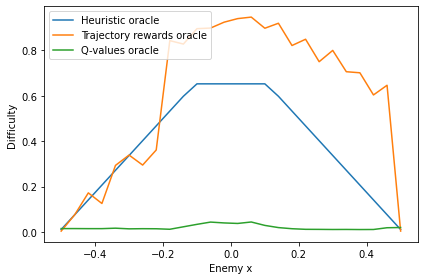

In [41]:
# %matplotlib qt
%matplotlib inline
set_matplotlib_colors(matplotlib, text_color="black", label_color="black", other_color="black")

fig, axs = plt.subplots()
axs.plot(states, evaluations_h)
axs.plot(states, evaluations_r)
axs.plot(states, evaluations_q)
axs.legend(["Heuristic oracle", "Trajectory rewards oracle", "Q-values oracle"])
axs.set_xlabel("Enemy x")
axs.set_ylabel("Difficulty")
fig.tight_layout()
plt.show()

### Training evaluator

...using the ***Trajectory rewards*** oracle

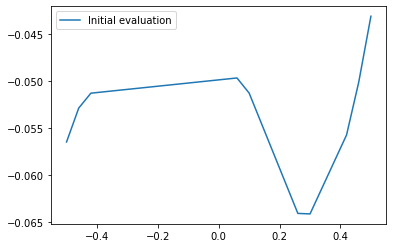

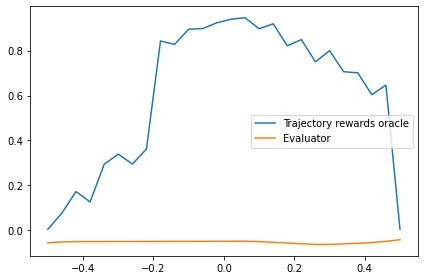

In [51]:
# Create our NN evaluator
embedding_size = 1
evaluator = MLP(in_size=embedding_size, out_size=1, hidden=[8, 8], activation=LeakyReLU())
optim = Adam(evaluator.parameters(), lr=0.01)
scheduler = StepLR(optim, 10000, 0.1)
states_ = torch.tensor(states).unsqueeze(-1)

# Example difficulty
with torch.no_grad():
    difficulty_initial = evaluator(states_)
plt.plot(states, difficulty_initial)
plt.legend(["Initial evaluation"])
plt.show()

_, axs = plt.subplots()
axs.plot(states, evaluations_r)
axs.plot(states, evaluator(states_).detach())
axs.legend(["Trajectory rewards oracle", "Evaluator"])
plt.tight_layout()
plt.show()

It. 10000 loss=0.00108 lr=0.001


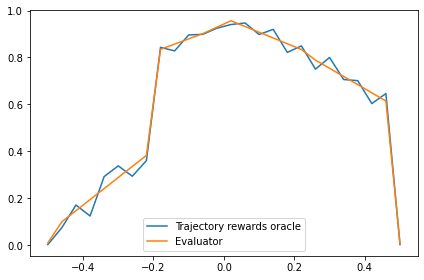

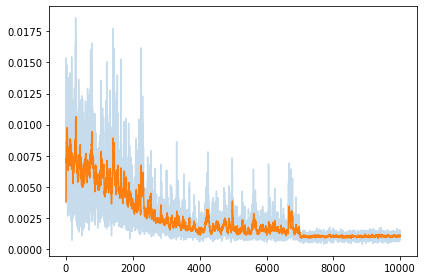

In [56]:
%matplotlib inline
# Training loop
i = 0
loss = float("inf")
real = torch.stack(evaluations_r)
losses = []

def plot():
    clear_output(wait=True)
    print(f"It. {i} loss={loss.item():.5f} lr={scheduler.get_last_lr()[0]}")

    _, axs = plt.subplots()
    axs.plot(states, evaluations_r)
    axs.plot(states, evaluator(states_).detach())
    axs.legend(["Trajectory rewards oracle", "Evaluator"])
    plt.tight_layout()
    plt.show()

    _, axs = plt.subplots()
    axs.plot(losses, alpha=0.25)
    axs.plot(running_average(losses, 0.9), label="Evaluator's loss")
    plt.legend()
    plt.tight_layout()
    plt.show()

while i < 10000:
    sample, indices = sample_from(states_, 15, indices=True)

    d_predicted = evaluator(sample)
    d_real = real[indices]

    loss = F.mse_loss(d_real, d_predicted)
    losses.append(loss.item())

    optim.zero_grad()
    loss.backward()
    optim.step()
    scheduler.step()

    if i % 100 == 0:
        plot()

    i += 1

save(evaluator, "./saved_data/evaluator.plt")
print("saved to ./saved_data/evaluator.plt")

plot()

In [61]:
%matplotlib qt
plot()

It. 10000 loss=0.00108 lr=0.001


In [62]:
# %matplotlib qt
# Once trained we can plot the evaluation

evaluator = load("./saved_data/evaluator.plt")

plt.plot(states, evaluations_r)
plt.plot(states, evaluator(states_).detach())
plt.legend(["Trajectory rewards oracle", "Evaluator"])
plt.tight_layout()
plt.show()

It.: 512, difficulty_loss=0.06853 offsets_loss=0.06331


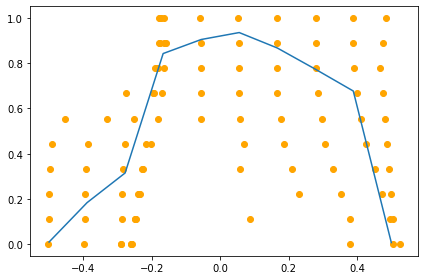

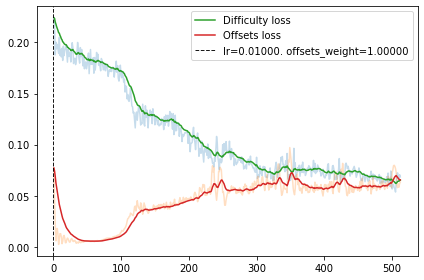

In [114]:
%matplotlib inline

# Now we can train the generator
state = env.get_starting_state()
states = torch.stack([state.clone() for _ in range(100)])
enemy_xs = torch.linspace(enemy_x_min, enemy_x_max, states.shape[0]).unsqueeze(-1)
states.enemy_x = enemy_xs


bounds = torch.tensor([[enemy_x_min, enemy_x_max]])
generator = SeededGenerator(bounds, hidden=[8, 16, 8], activation=LeakyReLU(), optimizer_class=Adam, lr=0.01)
scheduler = StepLR(generator.optim, 1000, 0.75)

evaluator = load("./saved_data/evaluator.plt")

num_difficulties = 100
num_seeds = 100

# Our dataset of [difficulty, seed] inputs
difficulties = torch.linspace(0, 1, num_difficulties)
seeds = torch.linspace(enemy_x_min, enemy_x_max, num_seeds)
dataset = torch.cartesian_prod(difficulties, seeds)

# For rendering
r_difficulties = torch.linspace(0, 1, 10)
r_seeds = torch.linspace(enemy_x_min, enemy_x_max, 10)
r_dataset = torch.cartesian_prod(r_difficulties, r_seeds)

iteration = 0
loss_evaluator = float("inf")

state = env.get_starting_state()


losses_difficulty = []
losses_offsets = []
iterations = []
lrs = [scheduler.get_last_lr()[0]]
weights = [generator.offsets_weight]
step = 1000
step_current = step

def iterate(verbose=False):
    global dataset, iteration, step_current

    # Sample from the dataset
    indices = torch.randperm(dataset.shape[0])[:1000]
    sample = dataset[indices]

    # Generate levels
    generated_levels = generator(sample)

    d_out = evaluator(generated_levels)

    # Train the generator on the evaluated difficulty
    loss_difficulty, loss_offsets = generator.update(d_out)
    scheduler.step()

    iteration += 1

    if iteration > step_current:
        generator.offsets_weight *= 0.1

        lrs.append(scheduler.get_last_lr()[0])
        weights.append(generator.offsets_weight)
        step_current += step

    iterations.append(iteration)
    losses_difficulty.append(loss_difficulty.item())
    losses_offsets.append(loss_offsets.item())

    if verbose:
        clear_output(wait=True)
        print(f"It.: {iteration}, "
              f"difficulty_loss={loss_difficulty.item():.5f} "
              f"offsets_loss={loss_offsets.item():.5f}")

        generated_states = generator(r_dataset).detach()

        d_out = evaluator(generated_states).detach()

        collected = torch.hstack((r_dataset, generated_states, d_out))

        fix, ax = plt.subplots()

        for i in range(r_seeds.shape[0]):
            selected = collected[i::r_difficulties.shape[0], :]
            ds, xs = selected[:, 0], selected[:, 2]
            ax.scatter(xs, ds, color="orange")

        ax.plot(r_seeds, evaluator(r_seeds.unsqueeze(-1)).detach())

        plt.tight_layout()

        plt.show()

        _, ax = plt.subplots()
        ax.plot(iterations, losses_difficulty, alpha=0.25)
        ax.plot(iterations, losses_offsets, alpha=0.25)
        ax.plot(iterations, running_average(losses_difficulty, 0.9), label="Difficulty loss")
        ax.plot(iterations, running_average(losses_offsets, 0.9), label="Offsets loss")

        s = 0
        for lr, w in zip(lrs, weights):
            ax.axvline(x=s, c="black", linestyle="--", alpha=0.9, linewidth=1, label=f"lr={lr:.5f}. offsets_weight={w:.5f}")
            s += step

        ax.legend()
        plt.tight_layout()

        plt.show()


iterate()

try:
    for _ in range(10):
        for _ in range(50):
            iterate()
        iterate(True)
except KeyboardInterrupt:
    pass

iterate(True)

In [ ]:
try:
    for _ in range(10):
        for _ in range(50):
            iterate()
        iterate(True)
except KeyboardInterrupt:
    pass

iterate(True)


It.: 7513, difficulty_loss=0.00178 offsets_loss=0.17127


KeyboardInterrupt: 

In [70]:
%matplotlib qt
iterate(True)

It.: 3579, difficulty_loss=0.00269 offsets_loss=0.17932
